In [1]:
import numpy as np
import xarray as xr
import re
from pathlib import Path
import collections
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.font_manager as fm

from utils import *

In [2]:
# CONFIGURE SCRIPT
# Where to find Alchemist data files
directory = '../data'
# Where to save charts
output_directory = 'custom-charts'
# How to name the summary of the processed data
pickleOutput = 'data_summary'
# Experiment prefixes: one per experiment (root of the file name)
experiments = ['export']
floatPrecision = '{: 0.3f}'
# Number of time samples 
timeSamples = 80
# time management
minTime = 60
maxTime = 12 * 3600
timeColumnName = 'time'
logarithmicTime = False
# One or more variables are considered random and "flattened"
seedVars = ['seed']
# Label mapping


In [3]:
if os.path.exists(directory):
    newestFileTime = max([os.path.getmtime(directory + '/' + file) for file in os.listdir(directory)], default=0.0)
    try:
        lastTimeProcessed = pickle.load(open('timeprocessed', 'rb'))
    except:
        lastTimeProcessed = -1
    shouldRecompute = not os.path.exists(".skip_data_process") and newestFileTime != lastTimeProcessed
    if not shouldRecompute:
        try:
            means = pickle.load(open(pickleOutput + '_mean', 'rb'))
            stdevs = pickle.load(open(pickleOutput + '_std', 'rb'))
        except:
            shouldRecompute = True
    if shouldRecompute:
        timefun = np.logspace if logarithmicTime else np.linspace
        means = {}
        stdevs = {}
        for experiment in experiments:
            # Collect all files for the experiment of interest
            import fnmatch
            allfiles = filter(lambda file: fnmatch.fnmatch(file, experiment + '_*.csv'), os.listdir(directory))
            allfiles = [directory + '/' + name for name in allfiles]
            allfiles.sort()
            # From the file name, extract the independent variables
            dimensions = {}
            for file in allfiles:
                dimensions = mergeDicts(dimensions, extractCoordinates(file))
            dimensions = {k: sorted(v) for k, v in dimensions.items()}
            # Add time to the independent variables
            dimensions[timeColumnName] = range(0, timeSamples)
            # Compute the matrix shape
            shape = tuple(len(v) for k, v in dimensions.items())
            # Prepare the Dataset
            dataset = xr.Dataset()
            for k, v in dimensions.items():
                dataset.coords[k] = v
            if len(allfiles) == 0:
                print("WARNING: No data for experiment " + experiment)
                means[experiment] = dataset
                stdevs[experiment] = xr.Dataset()
            else:
                varNames = extractVariableNames(allfiles[0])
                for v in varNames:
                    if v != timeColumnName:
                        novals = np.ndarray(shape)
                        novals.fill(float('nan'))
                        dataset[v] = (dimensions.keys(), novals)
                # Compute maximum and minimum time, create the resample
                timeColumn = varNames.index(timeColumnName)
                allData = { file: np.matrix(openCsv(file)) for file in allfiles }
                computeMin = minTime is None
                computeMax = maxTime is None
                if computeMax:
                    maxTime = float('-inf')
                    for data in allData.values():
                        maxTime = max(maxTime, data[-1, timeColumn])
                if computeMin:
                    minTime = float('inf')
                    for data in allData.values():
                        minTime = min(minTime, data[0, timeColumn])
                timeline = timefun(minTime, maxTime, timeSamples)
                # Resample
                for file in allData:
#                    print(file)
                    allData[file] = convert(timeColumn, timeline, allData[file])
                # Populate the dataset
                for file, data in allData.items():
                    dataset[timeColumnName] = timeline
                    for idx, v in enumerate(varNames):
                        if v != timeColumnName:
                            darray = dataset[v]
                            experimentVars = extractCoordinates(file)
                            darray.loc[experimentVars] = data[:, idx].A1
                # Fold the dataset along the seed variables, producing the mean and stdev datasets
                mergingVariables = [seed for seed in seedVars if seed in dataset.coords]
                means[experiment] = dataset.mean(dim = mergingVariables, skipna=True)
                stdevs[experiment] = dataset.std(dim = mergingVariables, skipna=True)
        # Save the datasets
        pickle.dump(means, open(pickleOutput + '_mean', 'wb'), protocol=-1)
        pickle.dump(stdevs, open(pickleOutput + '_std', 'wb'), protocol=-1)
        pickle.dump(newestFileTime, open('timeprocessed', 'wb'))
else:
    means = { experiment: xr.Dataset() for experiment in experiments }
    stdevs = { experiment: xr.Dataset() for experiment in experiments }
    
for experiment in experiments:
    current_experiment_means = means[experiment]
    current_experiment_errors = stdevs[experiment]

In [72]:
consumptions = current_experiment_means[
    { 'batteryConsumption[sum]', 'cloudConsumption[sum]', 'totalConsumption[sum]' }
].mean(dim = { 'epi_ratio', 'device_count', 'cloud_epi', 'battery_discharge_time' }, skipna = True)

charging = current_experiment_means[
    { 'isCharging[sum]' }
].mean(dim = { 'epi_ratio', 'device_count', 'cloud_epi', 'battery_discharge_time' }, skipna = True)

batteryPercentage = current_experiment_means[
    { 'batteryPercentage[mean]' }
].mean(dim = { 'epi_ratio', 'device_count', 'cloud_epi', 'battery_discharge_time' }, skipna = True)

In [73]:
consumptions_mean = consumptions.mean(dim = { 'time' }, skipna = True)
consumption_df = consumptions_mean.to_dataframe().tail(-1)
consumption_df

cloudConsumption[sum]   
low_battery_threshold high_battery_threshold                          
0.0                   100.0                                0.000000  \
30.0                  70.0                              3085.527000   
                      100.0                             5043.652254   

                                              batteryConsumption[sum]   
low_battery_threshold high_battery_threshold                            
0.0                   100.0                                460.783967  \
30.0                  70.0                                 371.088713   
                      100.0                                305.341809   

                                              totalConsumption[sum]  
low_battery_threshold high_battery_threshold                         
0.0                   100.0                              460.761111  
30.0                  70.0                              3456.611437  
                      100.0                             5348.982117

In [74]:
charging_sum = charging.sum(dim = { 'time' }, skipna = True)
charging_df = charging_sum.to_dataframe().tail(-1)
charging_df

isCharging[sum]
low_battery_threshold high_battery_threshold                 
0.0                   100.0                       2305.354167
30.0                  70.0                        1605.866667
                      100.0                       1479.879167

<Axes: xlabel='low_battery_threshold,high_battery_threshold'>

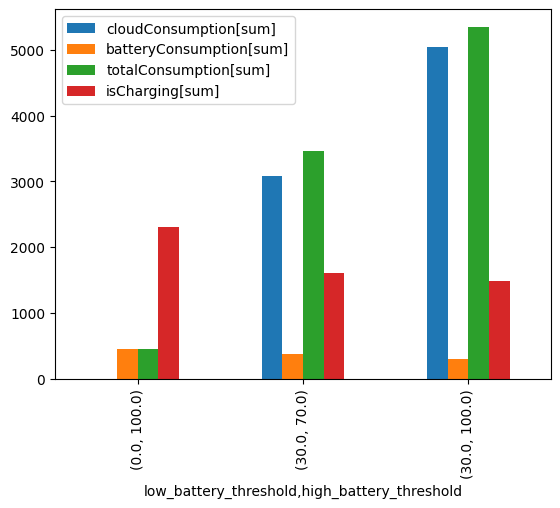

In [75]:
import pandas as pd
result = pd.concat([consumption_df, charging_df], axis=1, join='inner')
result.plot.bar()